In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'Arial'

import numpy as np
import pandas as pd
import seaborn as sns

from aind_analysis_arch_result_access.han_pipeline import get_session_table
from aind_analysis_arch_result_access.util.s3 import get_s3_pkl, get_s3_json

In [4]:
S3_ROOT = "s3://aind-behavior-data/foraging_nwb_bonsai_processed/"

def get_s3_logistic_regression(subject_id, session_date, nwb_suffix):
    session_path = subject_id + "_" + session_date + "_" + str(nwb_suffix) + "/"
    df_logistic = get_s3_pkl(S3_ROOT + session_path + subject_id + "_" + session_date + "_" + str(nwb_suffix) + "_df_session_logistic_regression_df_beta_Su2022.pkl")
    return df_logistic

def get_s3_logistic_regression_batch(subject_ids, session_dates, nwb_suffixs, max_threads_for_s3=10):
    """Get df_logistic_betas from s3 for a batch of sessions"""
    with ThreadPoolExecutor(max_workers=max_threads_for_s3) as executor:
        results = list(
            tqdm(
                executor.map(get_s3_logistic_regression, subject_ids, session_dates, nwb_suffixs),
                total=len(subject_ids),
                desc="Get logistic regression betas from s3",
            )
        )
    return pd.concat(results).reset_index()

In [5]:
# Get session table
df_session = get_session_table()

# Manually group curriculum versions (ver < 2.0, 2.0 <= ver < 2.3, ver >=2.3)
def _map_curriculum_ver(ver):
    if "2.3" in ver:
        return "v3"
    elif "1.0" in ver:
        return "v1"
    else:
        return "v2"

df_session["curriculum_version_group"] = df_session["curriculum_version"].map(_map_curriculum_ver)

In [13]:
STAGE_ORDER = [
    "STAGE_1_WARMUP",
    "STAGE_1",
    "STAGE_2",
    "STAGE_3",
    #"STAGE_4",
    "STAGE_FINAL",
    "GRADUATED",
]

df_logistic_all = dict()

for stage in STAGE_ORDER:
    df_filtered = df_session.query(f"current_stage_actual == '{stage}' and curriculum_name == 'Uncoupled Baiting' and curriculum_version_group == 'v3'")
    df_logistic_all[stage] = get_s3_logistic_regression_batch(
        df_filtered["subject_id"],
        df_filtered["session_date"].astype(str),
        df_filtered["nwb_suffix"],
        max_threads_for_s3=100,
    )

Get logistic regression betas from s3:   0%|          | 0/110 [00:00<?, ?it/s]

Get logistic regression betas from s3:  58%|█████▊    | 545/932 [00:04<00:02, 157.88it/s]Cannot find file at s3://aind-behavior-data/foraging_nwb_bonsai_processed/757214_2024-11-29_150620/757214_2024-11-29_150620_df_session_logistic_regression_df_beta_Su2022.pkl
Cannot find file at s3://aind-behavior-data/foraging_nwb_bonsai_processed/757210_2024-11-29_145902/757210_2024-11-29_145902_df_session_logistic_regression_df_beta_Su2022.pkl
Get logistic regression betas from s3: 100%|██████████| 754/754 [00:04<00:00, 160.93it/s]


In [14]:
def plot_logistic_regression_population(df_all, max_trials_back=10, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200,
                               gridspec_kw=dict(bottom=0.2, top=0.9))
        
    xx = np.arange(1, max_trials_back + 1)
    
    plot_spec = {'RewC': ('none', 'Reward choices', '-'), 
                 'UnrC': ('none', 'Unrewarded choices', '--'), 
                 'bias': ('>', 'Bias (right)', '-')}    

    for name, (marker, label, ls) in plot_spec.items():
        
        if name == "bias":
            means = df_all[name].mean()
            cis = df_all[name].sem() * 1.96
        else:
            means = [df_all[name][t].mean() 
                    for t in xx]
            cis = [df_all[name][t].sem() * 1.96 
                   for t in xx]
                
        ax.errorbar(x=1 if name == 'bias' else xx,
                    y=means,
                    yerr=cis,
                    ls=ls, 
                    marker=marker,
                    markersize=8,
                    color='k', 
                    capsize=5, markeredgewidth=1,
                    label=label + ' $\pm$95% CI',
                    ecolor='k',  # Direct color control so that errorbars are editable in InkScape
                    elinewidth=2)
    
    ax.set(xlabel='Past trials', ylabel='Logistic regression coeffs')
    ax.axhline(y=0, color='k', linestyle=':', linewidth=0.5)
    ax.set(xticks=[1, 5, 10])

    n_mice = df_all['subject_id'].nunique()
    n_sessions = df_all.groupby(['subject_id', 'session_date']).ngroups
    ax.set(title=f'{n_mice} mice, {n_sessions} sessions')
    ax.set(ylim=[-0.2, 2.0])
    
    return ax

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

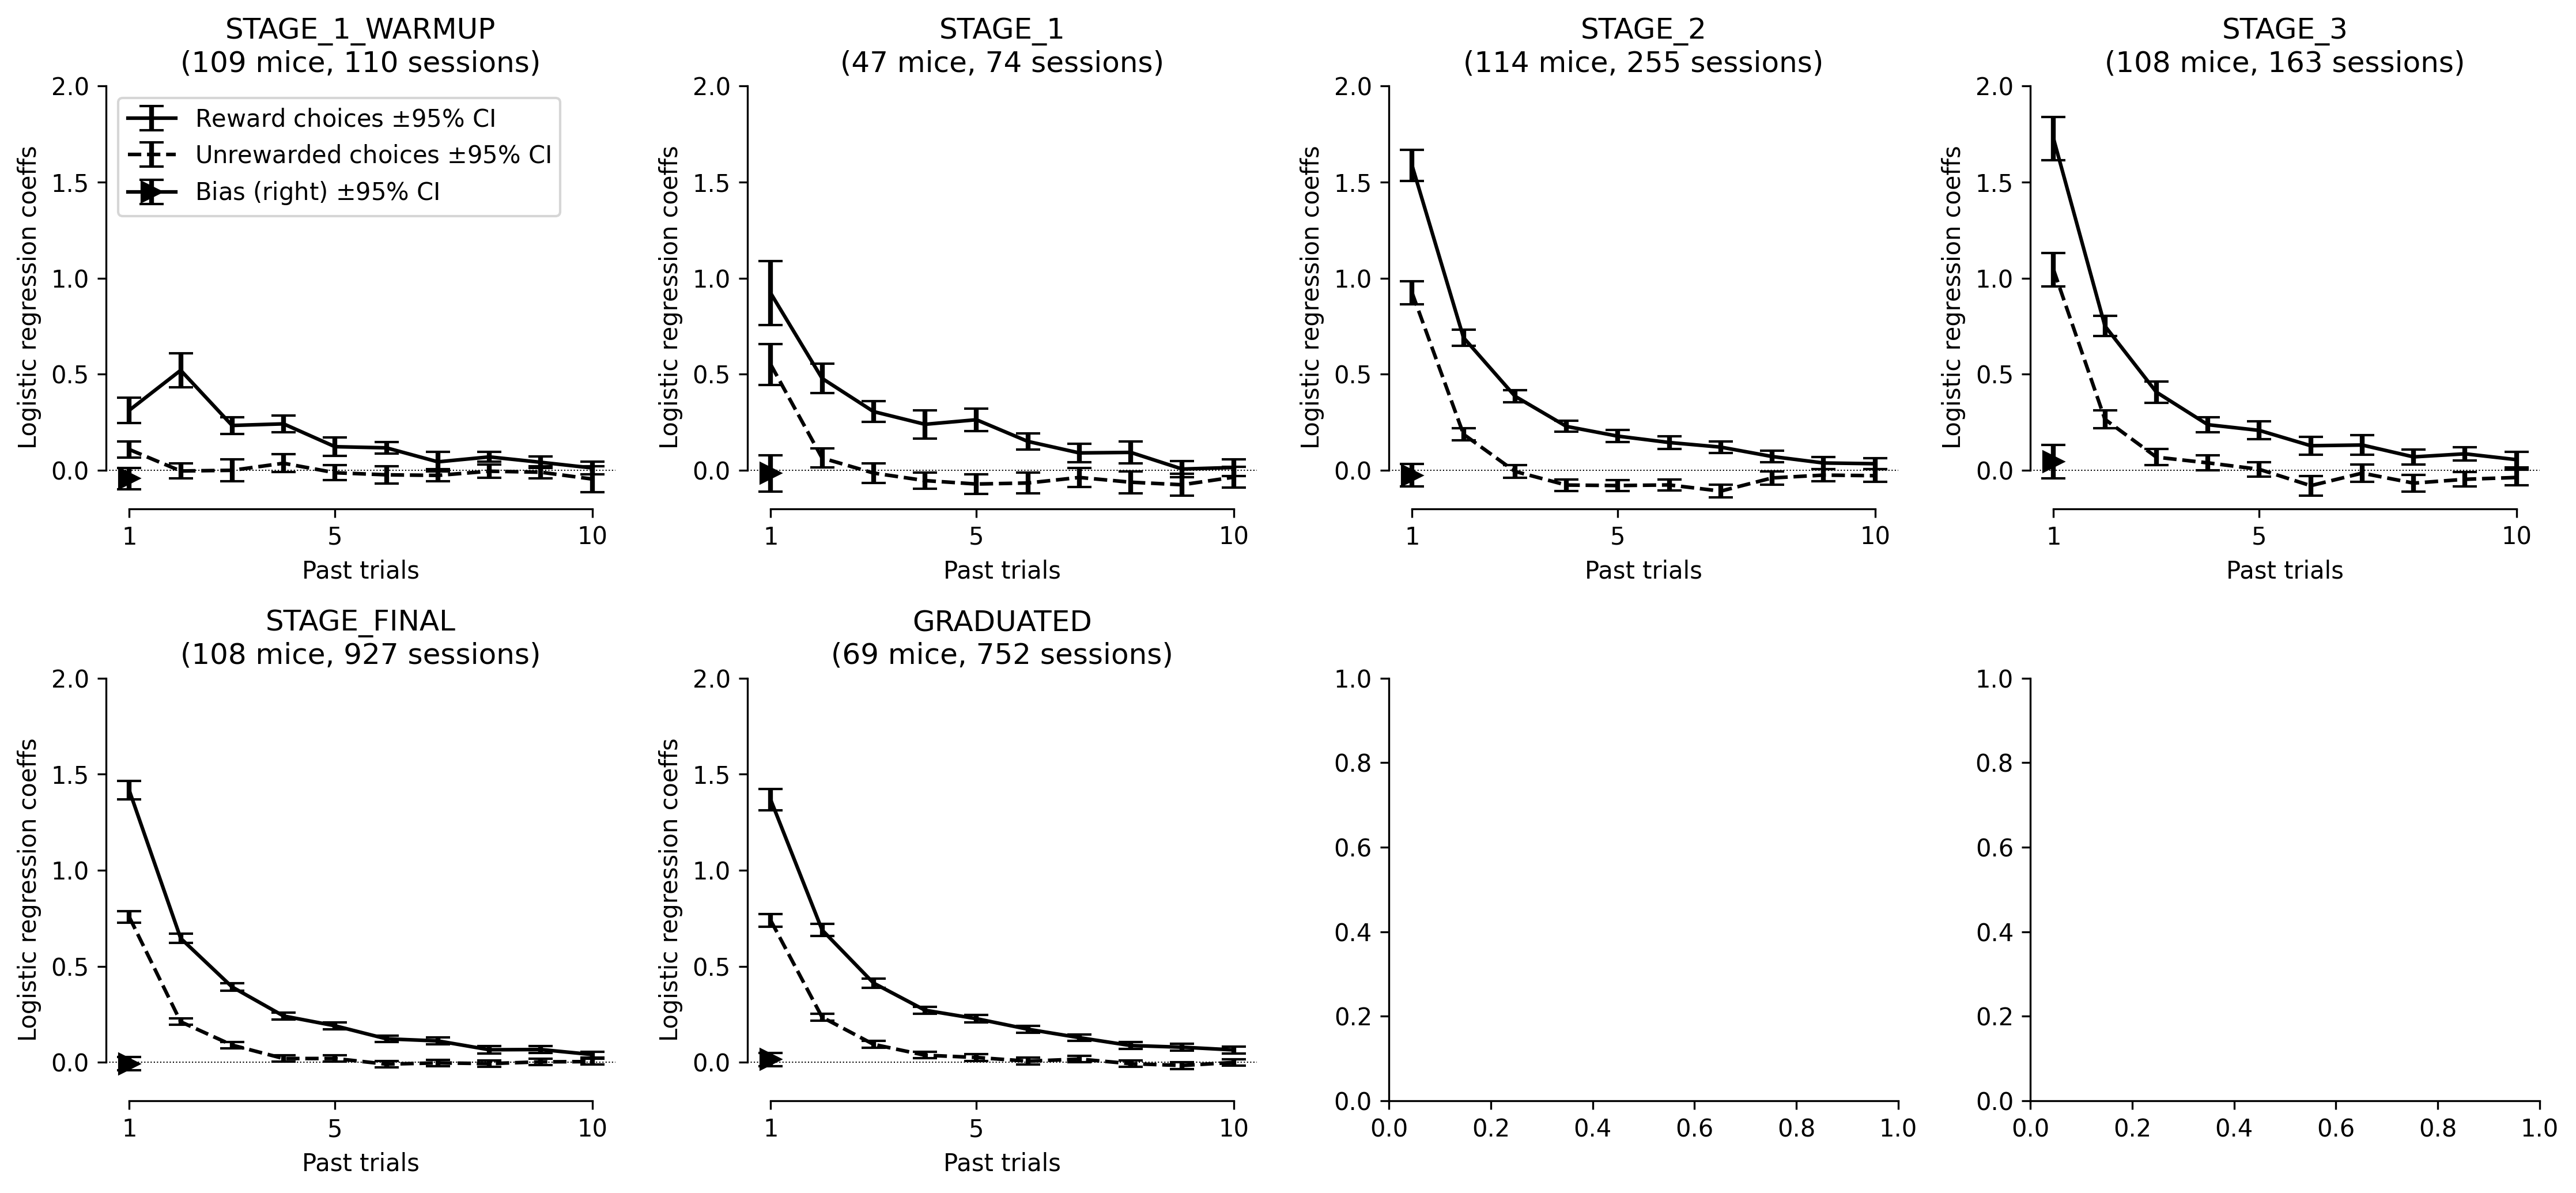

In [15]:
fig, axes = plt.subplots(2, 4, figsize=(15, 7), dpi=300)

for stage in STAGE_ORDER: 
    ax = axes.flatten()[STAGE_ORDER.index(stage)]
    plot_logistic_regression_population(df_logistic_all[stage], ax=ax)
    
    if stage == "STAGE_1_WARMUP":
        ax.legend(loc='upper left')
    ax.set(title=f"{stage}\n({ax.get_title()})")

sns.despine(trim=True)
fig.tight_layout()
fig.savefig("logistic_regression_betas_uncoupled_baiting.svg")

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_histograms_matplotlib(df, column, bins, use_kernel_smooth, use_density, stage_color_mapper, ax):
    """
    Plots histograms or kernel density estimates for each stage using Matplotlib.
    
    Parameters:
      df: DataFrame containing the data.
      column: The column name in df for which to compute the histogram/KDE.
      bins: The number of bins to use for the histogram or the bin edges for KDE.
      use_kernel_smooth: If True, use kernel smoothing via gaussian_kde.
      use_density: If True and not using kernel smoothing, normalize the histogram.
      stage_color_mapper: Dictionary mapping each stage to a color.
      
    Returns:
      fig, ax: The Matplotlib figure and axes objects.
    """
    # Prepare the overall bin edges based on the complete data (ignoring NaNs and infinite values)
    stage_data_all = df[column].dropna()
    stage_data_all = stage_data_all[~stage_data_all.isin([np.inf, -np.inf])]
    bin_edges = np.linspace(stage_data_all.min(), stage_data_all.max(), bins)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2  # midpoints for plotting
    
    # Loop through each category in 'current_stage_actual'
    for stage in df["current_stage_actual"].cat.categories:
        if stage not in df["current_stage_actual"].unique():
            continue
        
        # Filter the DataFrame for the current stage and drop missing values
        stage_df = df[df["current_stage_actual"] == stage][[column, "subject_id"]].dropna()
        n_sessions = len(stage_df)
        n_mice = stage_df["subject_id"].nunique()
        stage_data = stage_df[column]
        
        # Compute histogram or kernel density estimate
        if use_kernel_smooth:
            if len(stage_data.unique()) == 1:
                unique_value = stage_data.iloc[0]
                # Fallback KDE: create a narrow Gaussian centered on the unique value
                kde = lambda x: np.exp(-((x - unique_value) ** 2) / (unique_value/100))
            else:
                kde = gaussian_kde(stage_data)
            y_vals = kde(bin_centers)
        else:
            # Compute histogram counts (or density) using numpy
            y_vals, _ = np.histogram(stage_data, bins=bin_edges, density=use_density)
        
        # (Optional) Compute percentiles for each bin edge if you need them for further processing
        percentiles = [(np.sum(stage_data <= x) / len(stage_data)) * 100 for x in bin_edges[1:]]
        
        # Plot the line for this stage
        label = f"{stage} ({n_mice} mice, {n_sessions} sessions)"
        ax.plot(bin_centers, y_vals, label=label, color=stage_color_mapper.get(stage, None))
    
    # Set axis labels
    ax.set_xlabel(column)
    if use_kernel_smooth:
        ylabel = "Kernel density"
    elif use_density:
        ylabel = "Density"
    else:
        ylabel = "Count"
    ax.set_ylabel(ylabel)
    
    return ax


In [17]:
import matplotlib

def get_stage_color_mapper(stage_list):
    # Mapping stages to colors from red to green, return rgb values
    # Interpolate between red and green using the number of stages
    cmap = matplotlib.colormaps['RdYlGn']
    stage_color_mapper = {
        stage: matplotlib.colors.rgb2hex(
            cmap(i / (len(stage_list) - 1))) 
        for i, stage in enumerate(stage_list)
    }
    stage_color_mapper.update({"STAGE_3": "#ecedab"})  # Better contrast
    return stage_color_mapper

stage_color_mapper = get_stage_color_mapper(STAGE_ORDER)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

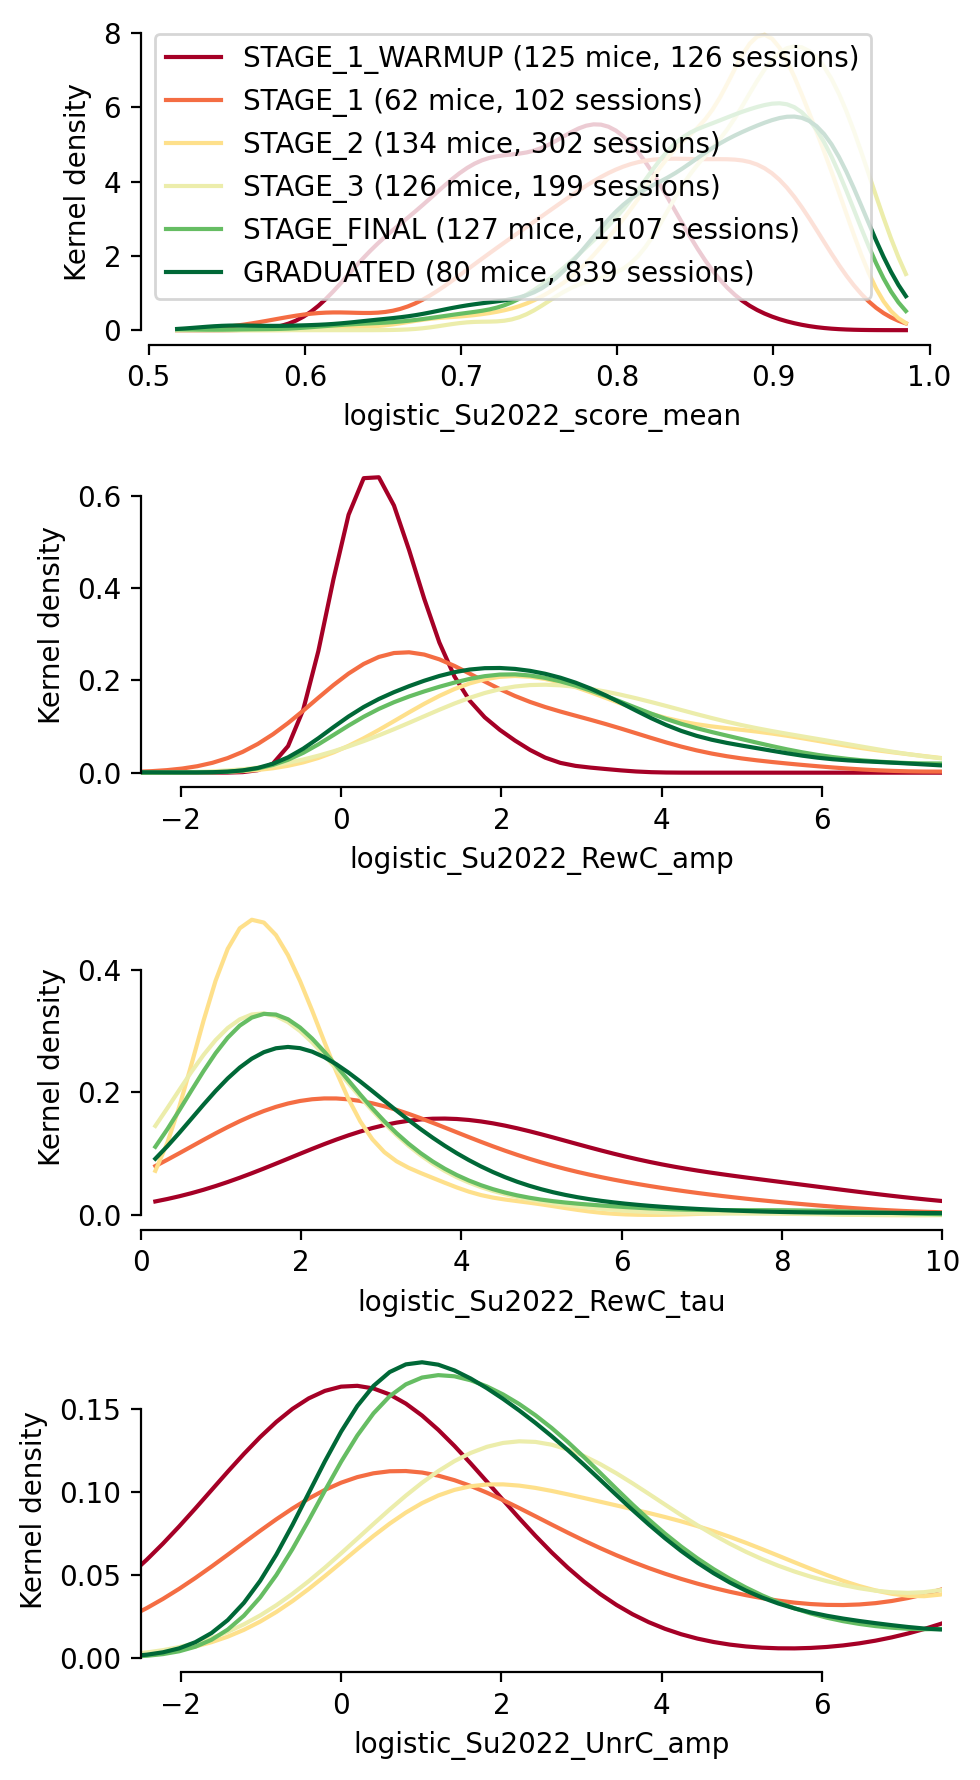

In [18]:
bins = 100

df_session["current_stage_actual"] = pd.Categorical(
    df_session["current_stage_actual"], categories=STAGE_ORDER, ordered=True
)
df_session = df_session.sort_values("current_stage_actual")

selected_perf_columns = {
    "logistic_Su2022_score_mean": None,
    "logistic_Su2022_RewC_amp": [-2.5, 7.5],
    "logistic_Su2022_RewC_tau": [0, 10],
    "logistic_Su2022_UnrC_amp": [-2.5, 7.5],
}

selected_columns = selected_perf_columns

# Create a density plot for each selected column grouped by 'current_stage_actual'
unique_curriculum_name = ['Uncoupled Baiting']

fig, axes = plt.subplots(4, 1, figsize=(5, 9), dpi=200)

for curriculum_name in [name for name in unique_curriculum_name if name != "None"]:
    for n, (column, xlim) in enumerate(selected_columns.items()): 
        plot_histograms_matplotlib(
            df_session[df_session["curriculum_name"] == curriculum_name],
            column,
            bins,
            use_kernel_smooth=True,
            use_density=True,
            stage_color_mapper=stage_color_mapper,
            ax=axes[n],
        )
        if n == 0:
            axes[n].legend()
        if xlim:
            axes[n].set(xlim=xlim)

sns.despine(trim=True)
fig.tight_layout()

fig.savefig("logistic_regression_distribution_over_time.svg")